In [11]:

""" 

Simple fly motor neuron model with NA/K pump as described in
Megwa, Pascual, Gunay, Pulver, Prinz (2023)
(called 'the paper' in comments below) 

units in this code: unless otherwise noted, 
- times are in ms
- voltages are in mV
- currents are in pA
- conductances are in nS
- concentrations are in M (molar)
- capacitance is in pF

"""

# =============================================================================
# Initalization
# =============================================================================
import pylab as plt
from scipy.integrate import odeint
import numpy as np
from scipy.signal import find_peaks
from scipy import signal
from datetime import datetime
import csv

# =============================================================================
# Global Cell Parameters
# =============================================================================
### Conductances
sf = 1.0 
""" A scaling factor to scale all the conductances up or down"""
g_Ks = 50.0 * sf
"""Slow Potassium (K) maximum conductance, in nS"""
g_Kf = 15.1 * sf
"""Fast Potassium (K) maximum conductance, in nS"""
g_NaP = 0.80 * sf
"""Persistent Sodium (Na) maximum conductance, in nS"""
g_NaT = 100.0 * sf
"""Transient Sodium (Na) maximum conductance, in nS"""
g_leak_Na = 1.2 * sf
""" Sodium (Na) leak conductance, in nS""" 
g_leak_K = 3.75 * sf 
""" Potassium (Na) leak conductance, in nS""" 

### Membrane Constants
C_m = 4.0
"""Membrane capacitance, in pF"""
E_K = -80.0
"""Potassium (K) reversal potential, in mV"""
F = 96485.3329e15
"""Faraday's constant, in  pA*ms/mol"""
volume = 5.4994e-13 #corresponding to 549 um^3
"""Cell volume, in L"""
nao = 0.135 # or 135 milimolar (mM)
"""External [Na], in M, from O'Dowd and Aldrich (1988)"""


"External [Na], in M, from O'Dowd and Aldrich (1988)"

In [12]:

# =============================================================================
# Switches for the Model Settings and Injectors
# =============================================================================
### Model Version Settings Corresponding to the Paper

# [1,0,0] "ConCon" ~ constant sodium concentration, constant sodium reversal
# [1,1,0] "DynCon" ~ dynamic sodium concentration, constant sodium reversal
# [1,1,1] "DynDyn" ~ dynamic sodium concentration, dynamic sodium reversal

pumpswitch = 1      # If pumpswitch = 0, then pump is absent
                    # If pumpswitch = 1, then pump is present

NaiSwitch = 1   # If NaiSwitch = 0, then sodium concentration is constant
                # If NaiSwitch = 1, then sodium concentration is dynamic

dynrevswitch = 1    # If dynrevsitch = 0, then sodium reversal is constant
                    # If dynrevsitch = 1, then sodium reversal is dynamic
                    
model_switchsettings = [pumpswitch, NaiSwitch, dynrevswitch]

def E_NaSwitch(nai):
    switch = dynrevswitch
    if switch == 0:
        return 31.2 + 0 * np.log(nao/nai) # returns constant sodium reversal potential of 31.2
    elif switch == 1:
        return 25.694 * np.log(nao/nai) # returns the Na Nernst potential based on momentary sodium concentration and temperature 26 Celsius

### Switches for the different injection current types
# Switch ON = 1, Switch OFF = 0
inj_switch = 1      # for step current injection

# =============================================================================
# Time Vector (Global)
# =============================================================================
dt = .05 # default time increment, in milliseconds
inv_dt = int(1/dt) # inverse of dt

tHold = 5*1000 # pre-injection duration, time in ms 
tPulse = 5*1000 # injection duration, time in ms
tPulseEnd = tHold+tPulse # end of current injection, time in ms
tPost = 15*1000 # duration of the simulation after the current injection, time in ms
t_end = tHold+tPulse+tPost # full simulation time in ms

t_vec = np.arange(t_end, step=dt) # vectorizing the simulation time, containing indexes

# =============================================================================
# Current Clamp Parameters
# =============================================================================
I_hold = 0.0 # Constant Holding Current, in pA

inj_start = 70.0 # Initial Step Current in Step Current Loop, if enabled
inj_int = 50 # Step Current Increment in Step Current Loop, if enabled
inj_last = 150 # Last Step Current Step in Step Current Loop, if enabled

inj = np.arange(inj_start, inj_last + 20, inj_int) 
# Full Array of Step Currents for Loop, format is (start, end, increment)'''
print(inj)

[ 70. 120.]


In [13]:

# =============================================================================
# Initial Conditions of Dynamic Variables
# =============================================================================
# This starting condition has all the activation gates de-activated (set to 0.0)
# and all the inactivation gates de-inactivated (set to 1.0)
V0 = -59.9312 # membrane voltage, based on resting membrane potential of DynDyn model with default pump parameters
mNaT0 = 0.0 # NaT activation
hNaT0 = 1.0 # NaT inactivation
mNaP0 = 0.0 # NaP activation
n0 = 0.0 # Ks activation
dmKfdt0 = 0.00 # Kf activation
dhKf1dt0 = 1.0 # Kf1 inactivation 
dhKf2dt0 = 1.0 # Kf2 inactivation
Nai0 = 0.0400811 # internal sodium concentration, based on resting sodium concentration of DynDyn model with default pump parameters
param0 = np.array([V0, mNaT0, hNaT0, mNaP0, n0, dmKfdt0, dhKf1dt0 ,dhKf2dt0, Nai0])
""" param0 creates array of initial conditions to be used in integration function"""

# =============================================================================
# The Leak Currents (Sodium and Potassium)
# =============================================================================
def I_leak_NA(V, nai): # Sodium Component of Leak Membrane current (in pA)
    return  g_leak_Na * (V - E_NaSwitch(nai))

def I_leak_K(V): # Potassium Component of Leak Membrane current (in pA)
    return  g_leak_K * (V - E_K)

# =============================================================================
# NaT Current (Transient Sodium) - uses equations from Lin et al, 2012 (which is cited in 'the paper')    
# =============================================================================
def minf_NaT(V):
    return  1 / (1 + np.exp((V + 29.13) / (-8.922)))
def mtau_NaT(V):
    return 3.861 - 3.434 / (1.0 + np.exp((V + 51.35) / (-5.98))) 
def hinf_NaT(V):
    return 1 / (1 + np.exp((V + 40.0) / 6.048)) # adjusted from Lin et al, 2012 
def htau_NaT(V):
    return 2.834 - 2.371 / (1.0 + np.exp((V + 21.9) / (-2.641))) # adjusted from Gunay et al, 2015 (which is cited in 'the paper')
def I_NaT(V, mNaT, hNaT, nai):
    return g_NaT * mNaT**3 * hNaT * (V - E_NaSwitch((nai))) # adjusted from Gunay et al, 2015 (which is cited in 'the paper')

# =============================================================================
# NaP Current (Persistent Na)
# =============================================================================
def minf_NaP(V):
    return 1 / (1 + np.exp((V + 48.77)/(-3.68)))
def mtau_NaP(V):
    return 1
def I_NaP(V, mNaP, nai):
    return g_NaP * mNaP * (V - E_NaSwitch(nai))

# =============================================================================
# Ks Current (Slow Potassium)
# =============================================================================
def ninf_Ks(V):
    return 1 / (1 + np.exp((V + 12.85)/(-19.91)))
def ntau_Ks(V):
    return 2.03 + 1.96 /(1 + np.exp((V - 29.83)/3.32))
def I_Ks(V, n):
    return g_Ks * n**4 * (V - E_K)

# =============================================================================
# Kf Current (Fast Potassium)
# =============================================================================    
def minf_Kf(V):
    return 1 / (1 + np.exp((V + 17.55)/(-7.27)))
def mtau_Kf(V):
    return 1.94 + 2.66 / (1 + np.exp((V - 8.12)/7.96))
def hinf1_Kf(V):
    return 1 / (1 + np.exp((V + 45.0)/6.0))
def htau_Kf(V):
    return 1.79 + 515.8 / (1 + np.exp((V + 147.4)/(28.66)))
def hinf2_Kf(V):
    return 1 / (1 + np.exp((V + 44.2) / 1.5))
def I_Kf(V, mKf, hKf1, hKf2):
    return g_Kf * mKf**4 * (0.95*hKf1 + 0.05*hKf2) * (V - E_K)

# =============================================================================
# Na/K Pump Current
# =============================================================================
Imaxpump = 80.0 # maximal pump current, in pA
Imaxpump_start = 80.0 # Initial Imaxpump in Imaxpump Loops, if enabled
    
naih = 40 * 10**(-3) # sodium concentration of pump half activation, in M (molar)
naiH_start = 25.0 * 10**(-3) # Initial naiH in naiH Loops, if enabled
 
nais = 10.0 * 10**(-3) # pump slope factor, in M (molar)
nais_start = 10.0 * 10**(-3) # Initial nais in nais Loops, if enabled

### Default pump parameters in 'the paper' are Imaxpump = 75pA , naih = 40 mM, nais = 10 mM

# =============================================================================
# Simulation Settings - For Loops
# =============================================================================

# ### Uncomment the 3 lines below for multiple IMaxPump simulations
# Imaxpump_end = 200 + 0.001            # Final Imaxpump in Imaxpump Loop, if enabled
# Imaxpump_step = 5                     # Imaxpump increment in Imaxpump Loop, if enabled
# Imaxpump_range = np.arange(Imaxpump_start , Imaxpump_end, Imaxpump_step)

# ### Uncomment lines the 3 lines below for multiple nais simulations
# nais_end = (40 + .0001) * 10**(-3)    # Final nais in nais Loop, if enabled
# nais_step = 0.5 * 10**(-3)            # nais increment in nais Loop, if enabled
# nais_range = np.arange(nais_start , nais_end,nais_step)

# ### Uncomment lines the 3 lines below for multiple naih simulations
naiH_end = (90 + .0001) * 10**(-3)      # Final naih in naih Loop, if enabled
naiH_step = 1000.0 * 10**(-3)           # naih increment in naih Loop, if enabled
naiH_range = np.arange(naiH_start , naiH_end, naiH_step)


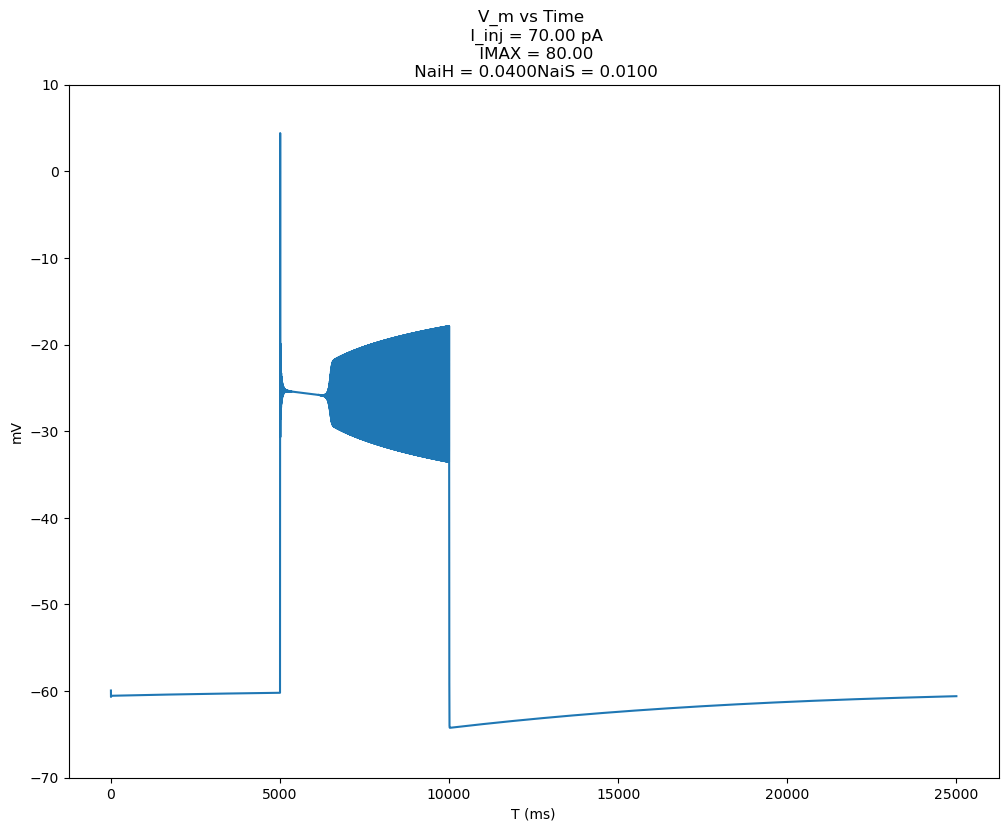

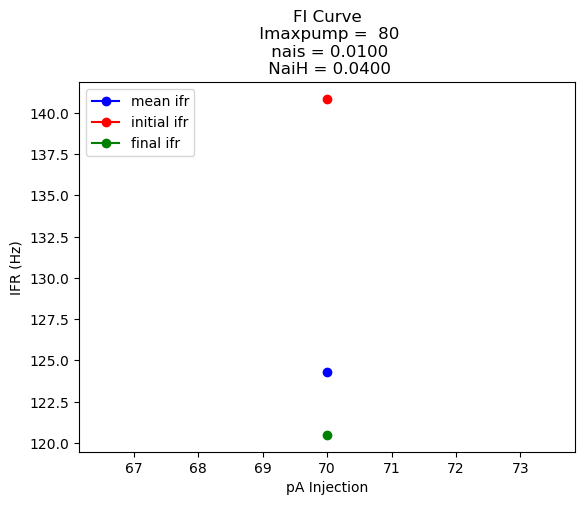

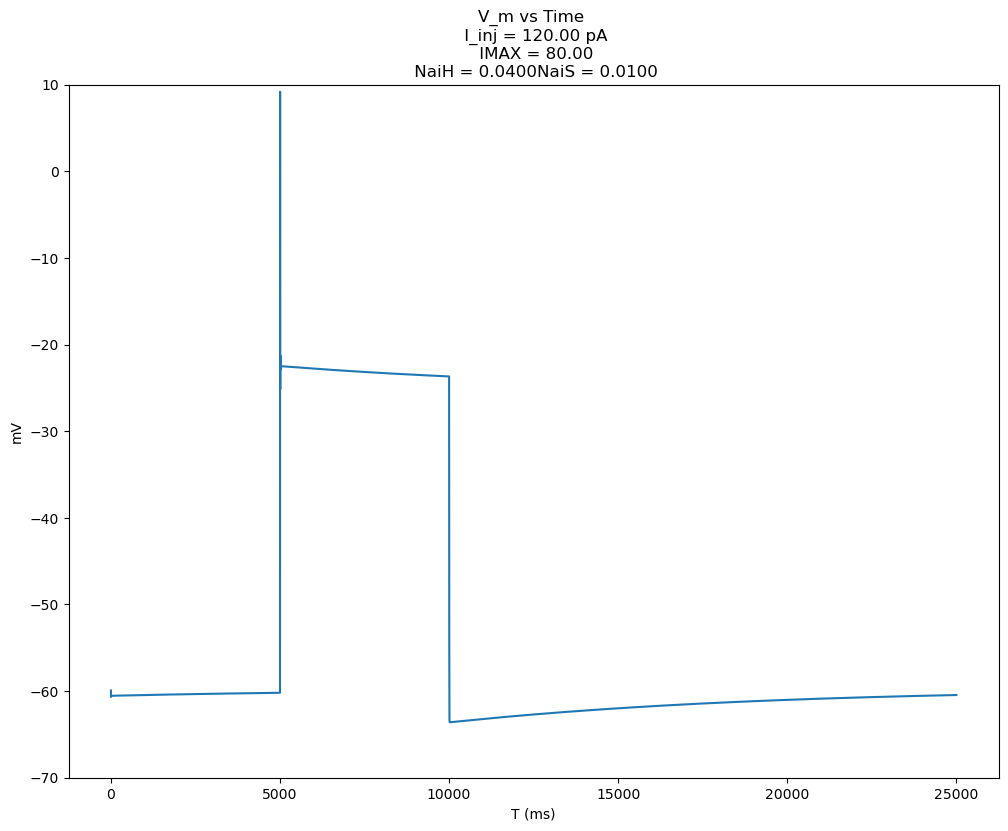

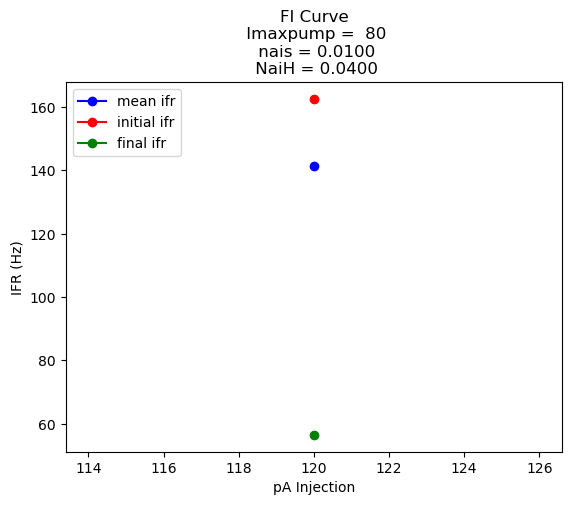

In [14]:
# =============================================================================
# Run Simulation
# =============================================================================

### This code has loop functions that allow sweeping through different parameter settings.
### Comment in and out as needed.
### Make sure to comment in the corresponding line at the end of the loop.

#while sf < sf_end:                     ### commented out, this would sweep scaling factor sf
#while Imaxpump < Imaxpump_end:         ### commented out, this would sweep Imaxpump
#while nais < nais_end:                 ### commented out, this would sweep nais
#while naih < naiH_end:
### Creating a set of data arrays 
vmin = [] # minimum voltage during simulation 
ahp_amp = [] # amplitude (mV) of after-hyperpolarization
ahp_halfdur = [] # half duration of AHP
ahp_25dur = [] # quarter duration of AHP
ahp_75dur = [] # three-quarters duration of AHP 
mean_ifrs = [] # mean of all instantaneous firing rates (Hz)
mean_Vcell = [] # mean voltage (mV) of the trough between spikes
delay = [] # delay to first spike

for i in range(0, len(inj)): # loop that steps through different current injections, if enabled
    global I_pulse
    I_pulse = inj[i]

    def I_pump(nai): # defines Na/K pump current, function of sodium concentration
        return Imaxpump / (1 + (np.exp((naih - nai) / nais)))

    def I_inj(t): # defines holding current injection
        return I_hold*(t<tHold) + (I_hold + I_pulse)*(t>=tHold)*(t<tPulseEnd) + I_hold*(t>=tPulseEnd)*(t<t_end)

            
            
    ### ODEint (Runge-Kutta 4) Solver  
    def dALLdt(param_vec, t):
        """
        Integrate
        | :param param_vec:
        | :param t:
        | :return: array of 
        0- membrane potential, mV
        1- dmNaTdt    (NaT activation)
        2- dhNaTdt    (NaT inactivation)
        3- dmNaPdt    (NaP activation)
        4- dndt       (Ks activation) [aka nKs in 'the paper']
        5- dmKfdt     (Kf activation)
        6- dhKf1dt    (Kf-1 inactivation)
        7- dhKf2dt    (Kf-2 inactivation)
        8- dNaidt     (Internal [Na]), M/s (mol/(L*s))
        """

        V, mNaT, hNaT, mNaP, n, mKf, hKf1, hKf2, nai = param_vec
        
        dVdt        = (-1/C_m) * (I_Kf(V, mKf, hKf1, hKf2) + I_Ks(V, n)                        
                    + I_NaP(V, mNaP, nai) + I_NaT(V, mNaT, hNaT, nai)
                    + (I_leak_NA(V, nai) + I_leak_K(V)) + pumpswitch*I_pump(nai)
                    - inj_switch*I_inj(t) )
        
        dmNaTdt     = (minf_NaT(V) - mNaT) /  mtau_NaT(V) 
        dhNaTdt     = (hinf_NaT(V) - hNaT) /  htau_NaT(V)
        dmNaPdt     = (minf_NaP(V) - mNaP) /  mtau_NaP(V)
        dndt        = (ninf_Ks(V)  - n)    /  ntau_Ks(V)
        dmKfdt      = (minf_Kf(V)  - mKf)  /  mtau_Kf(V)
        dhKf1dt     = (hinf1_Kf(V) - hKf1) /  htau_Kf(V)
        dhKf2dt     = (hinf2_Kf(V) - hKf2) /  116 
        
        dNaidt  = NaiSwitch * (-1/(F*volume)) * ( I_NaT(V, mNaT, hNaT, nai) 
                + I_NaP(V, mNaP, nai)                      
                + I_leak_NA(V, nai) 
                + 3*pumpswitch*I_pump(nai))
        
        return np.array([dVdt, dmNaTdt, dhNaTdt, dmNaPdt, dndt, dmKfdt, dhKf1dt, dhKf2dt, dNaidt])

    ### adds up all the applied current injections
    Inj_injectors = inj_switch*I_inj(t_vec) 
            
    #Integrate
    y1 = odeint(dALLdt, param0, t_vec, rtol=1e-10, h0=.05, hmax=100.0)

    # Arrays of dynamic variables at each time point
    Vcell = y1[:,0] 
    mNaT  = y1[:,1]
    hNaT  = y1[:,2]
    mNaP  = y1[:,3]
    n     = y1[:,4]
    mKf   = y1[:,5]
    hKf1  = y1[:,6]
    hKf2  = y1[:,7]
    Nai   = y1[:,8]

    # Create 'baseline' = the membrane potential (mV) at 50 ms pre-injection
    V_preinj = Vcell[(tHold - 50)*inv_dt] 

    # Baseline values for other dynamic variables
    NaConc_preinj = Nai[(tHold - 50)*inv_dt]
    dynENA_preinj = 25.694 * np.log(nao/(NaConc_preinj))
    pump_preinj   = Imaxpump / (1 + (np.exp((naih - (NaConc_preinj)) / nais)))

    # AHP Peak Amplitude (find the minimum after current injection)
    Vcell_post = Vcell[tPulseEnd*inv_dt:]
    vmin_i = min(Vcell_post) # variable to store Hyperpolarization trough value
    vmin.append(vmin_i)
    ahp_amp_i = vmin_i - V_preinj 
    ahp_amp.append(ahp_amp_i)

    # Find time of AHP peak in ms
    z = Vcell.tolist() # make Vcell into a list
    vmin_idx = z.index(vmin_i) # find the index of time of AHP trough
    vmin_t = vmin_idx*dt # vmin time in ms

    # time of half of AHP trough amplitude
    ahp_half_i = ahp_amp_i * 0.5 # half of ahp trough amplitude in mV
    v_ahp_half_i = vmin_i - ahp_half_i # membrane voltage at half AHP trough, in mV
    vmin_thalf_i = np.argmax(Vcell[vmin_idx:] >v_ahp_half_i) # idx of half AHP post trough
    vmin_thalf_idx_i = vmin_idx + vmin_thalf_i # idx of half trough for entire simulation
    ahp_halfdur_i = vmin_thalf_i*dt # time to reach half trough in ms
    ahp_halfdur.append(ahp_halfdur_i)

    # Making AHP 75 and AHP 25 
    ahp_25_i = ahp_amp_i * 0.25 # quarter of ahp trough amplitude in mV
    v_ahp_25_i = vmin_i - ahp_25_i # membrane voltage at quarter AHP trough, in mV
    vmin_t_25_i = np.argmax(Vcell[vmin_idx:] > v_ahp_25_i) # idx of quarter AHP post trough
    vmin_t_25_idx_i = vmin_idx + vmin_t_25_i # idx of quarter trough for entire simulation
    ahp_25dur_i = vmin_t_25_i*dt # latency to reach quarter trough in ms
    ahp_25dur.append(ahp_25dur_i)

    ahp_75_i = ahp_amp_i * 0.75 # three-quarters of ahp trough amplitude in mV
    v_ahp_75_i = vmin_i - ahp_75_i # membrane voltage at quarter AHP trough, in mV
    vmin_t_75_i = np.argmax(Vcell[vmin_idx:] > v_ahp_75_i) # idx of three-quarters AHP post trough
    vmin_t_75_idx_i = vmin_idx + vmin_t_75_i # idx of three-quarters trough for entire simulation
    ahp_75dur_i = vmin_t_75_i*dt # latency to reach three-quarters trough in ms
    ahp_75dur.append(ahp_75dur_i)

    # Find voltage Peaks
    x = Vcell
    peaks, _ = find_peaks(x, height=-25) # height = threshold in mV 
    # find_peaks function outputs an index
    spktimes = peaks*dt # turns index into time, in ms
    spk_idx = np.arange(1, len(spktimes), 1)

    # removing artifactual spikes (spikes before stimulus starts)
    realspktimes = [] 
    for h in range(0,len(spktimes)):
        # use only spikes after the stimulus injection starts
        realspktimes.append(spktimes[h])   # put those into realspktimes array
        h = h+1
    realspktimes_array = np.array(realspktimes)
        
    # Calculate ISIs (Interspike Intervals) in ms
    isi = [] 
    for h in range(0,len(realspktimes)-1):
        isi.append((realspktimes[h+1]-realspktimes[h]))
        h = h+1

    # Removing last entry from realspktimes
    realspktimesminusone = [] 
    for h in range(0,len(realspktimes)-1):
        realspktimesminusone.append(realspktimes[h])
        h = h+1
    realspktimesminusone_array = np.array(realspktimesminusone)

    # Calculate IFR (Instantaneous Firing Rate), in Hz (Inverse of the ISI)
    realspktimes_s = realspktimes_array/1000 # from ms to s
    #print(realspktimes_s)
    ifr = []
    mean_ifr_i = []
    if len(realspktimes) > 1:
        for j in range(0, len(realspktimes)-1):
            ifr.append(1/(realspktimes_s[j+1]-realspktimes_s[j]))
            mean_ifr_i = np.mean(ifr)
            j = j+1
    else:
        mean_ifr_i = 0 
        ifr = [0]
    mean_ifrs.append(mean_ifr_i)   
    ifr_array = np.asarray(ifr)

    def plotVCell():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, Vcell)
        plt.title('V_m vs Time \n I_inj = %2.2f pA' %I_pulse
                    + '\n IMAX = %2.2f' %Imaxpump
                    # + '\n ZAP = %2.4f' %I_ZapMax
                    + '\n NaiH = %2.4f' %naih + 'NaiS = %2.4f' %nais) ### Added extra labels
        plt.xlabel('T (ms)')
        plt.ylabel('mV')
        plt.ylim(-70, 10)
        #axes = plt.gca()  
        #axes.yaxis.grid()
        plt.show()
    plotVCell() #Comment Out if you don't want to output the graphs
    
    def plotFI():
        "Plot initial, final and mean IFR per current injection"
        plt.figure()
        plt.plot(I_pulse, mean_ifrs[i], 'o-b', label = 'mean ifr')
        plt.plot(I_pulse, ifr[0]   , 'o-r', label = 'initial ifr')
        plt.plot(I_pulse, ifr[-1]  , 'o-g', label = 'final ifr')
        plt.legend(loc='upper left')
        plt.title('FI Curve'              
                + '\n Imaxpump = %3.0f' %Imaxpump               
                + '\n nais = %1.4f' %nais
                + '\n NaiH = %1.4f' %naih)
        plt.xlabel('pA Injection')
        plt.ylabel('IFR (Hz)')
    plotFI()
    #naih = naih + naiH_step


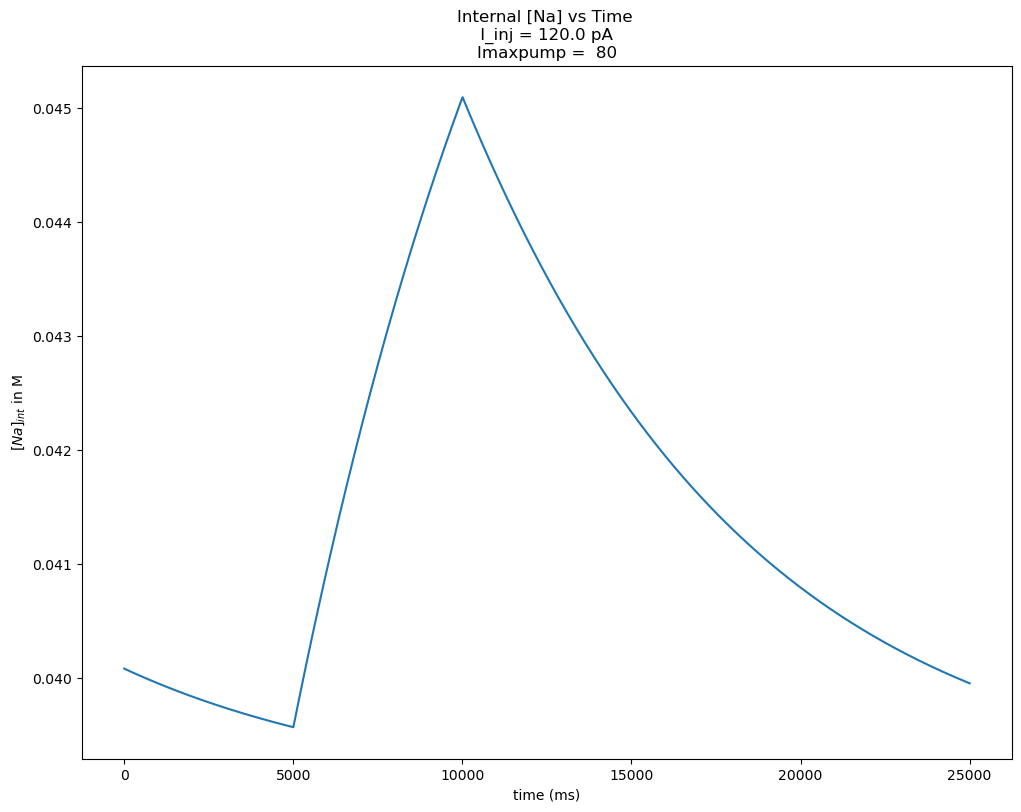

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

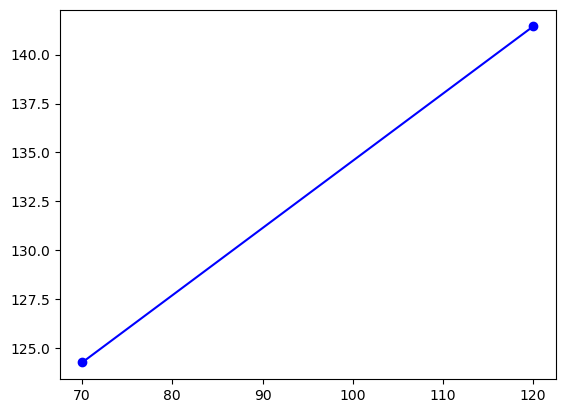

In [15]:
    

### Plotting Simulation Functions
# Plot Voltage and stars the Peaks
def plotPeaks():
    plt.figure(figsize=(12,9))
    plt.plot(x)
    plt.plot(peaks, x[peaks], "x")
    # plt.xlim((tHold-100)*inv_dt, (tPulseEnd+5000)*inv_dt) ## 100 ms before, 200 ms after current injection
    # plt.plot(np.zeros_like(x), "--", color="gray")
    plt.title('V vs T \n I_inj = %2.1f pA' %I_pulse)
    plt.xlabel('time in microseconds')
    plt.ylabel('mV')   
    plt.show()
#plotPeaks() #Comment Out if you don't want to output the graphs

# Plot the Voltage and stars troughs
def plotTroughs():
    x = Vcell
    plt.figure(figsize=(12,9))
    plt.plot(x)
    plt.plot(trough_clp, x[trough_clp], "x")
    plt.title('V vs T \n I_inj = %2.1f pA' %I_pulse)
    plt.xlabel('time in microseconds')
    plt.ylabel('mV')  
    plt.show()
#plotTroughs() #Comment Out if you don't want to output the graphs

# Plot VM (Membrane Voltage) vs Time, Main Voltage Plotting Function

# Plot Current Injection (all the different current injectors)
def plotInjCurrent():
    plt.figure(figsize=(12,9))
    plt.plot(t_vec,    inj_switch*I_inj(t_vec)) 
    plt.xlabel('time (ms)')
    plt.ylabel('Inj Current, pA')
    plt.title('Injection Current vs Time \n I_inj = %2.1f pA' %I_pulse
                + '\n Imaxpump = %3.0f' %Imaxpump)
    #plt.ylim(0,50) 
    plt.show()
#plotInjCurrent() #Comment Out if you don't want to output the graph



# Plot Internal Sodium Concentration [Na]
def plotNaint():
    plt.figure(figsize=(12,9))
    plt.plot(t_vec, Nai)
    plt.title('Internal [Na] vs Time \n '
                +'I_inj = %2.1f pA \n' %I_pulse 
                    + 'Imaxpump = %3.0f' %Imaxpump)
    plt.xlabel('time (ms)')
    plt.ylabel(r'$[Na]_{int}$ in M')
    #plt.ylim(0.0245, 0.0265) #Commented out to get an auto-generated range
    plt.show()
plotNaint() #Comment Out if you don't want to output the graphs

# Plot Pump Current
def plotIpump_i():
    plt.figure(figsize=(12,9))
    plt.plot(t_vec, I_pump(Nai))
    plt.xlabel('time (ms)')
    plt.ylabel('Pump Current, pA')
    plt.title('Pump Current vs Time \n I_inj = %2.1f pA' %I_pulse
                + '\n Imaxpump = %3.0f' %Imaxpump)
    # plt.ylim(0 , 1.1*Imaxpump) 
    plt.show()
#plotIpump_i() #Comment Out if you don't want to output the graph

# Plot Dynamic E_Na
def plotDynENa():
    plt.figure(figsize=(12,9))
    plt.plot(t_vec, E_NaSwitch(Nai))
    plt.xlabel('time (ms)')
    plt.ylabel('Na Reversal Potential (mV)')
    plt.title('Dynamic Sodium Reversal Potential (E_Na) vs T')
    plt.show()
#plotDynENa() #Comment Out if you don't want to output the graph

# Plot Instantenous Frequency
def plotISF():
    "Plot Instantenous Spike Frequnecy over the simulation time"
    plt.figure()
    plt.plot(realspktimesminusone_array, ifr_array, 'o-')
    plt.title('IFR Curve' + 'I_inj = %2.2f pA' %I_pulse               
        + '\n Imaxpump = %3.0f' %Imaxpump               
        + ', nais = %1.4f' %nais)
    plt.xlabel('time in ms')
    plt.ylabel('IFR (Hz)')
#plotISF()

# Plot Full Leak Current 
def plot_fullI_leak():
    plt.figure(figsize=(12,9))
    plt.plot(t_vec, I_leak_NA(Vcell, Nai) + I_leak_K(Vcell)) #remember to insert all the called parameters!
    plt.xlabel('time (ms)')
    plt.ylabel('Leak Current, pA')
    plt.title('Full Leak Current vs Time \n I_inj = %2.1f pA' %I_pulse
                + '\n Imaxpump = %3.0f' %Imaxpump)
    #plt.ylim(0,50) 
    plt.show()
#plot_fullI_leak() #Comment Out if you don't want to output the graph

# Plod Sodium [Na] Leak Current
def plotI_leakNA():
    plt.figure(figsize=(12,9))
    plt.plot(t_vec, I_leak_NA(Vcell, Nai)) #remember to insert all the called parameters!
    plt.xlabel('time (ms)')
    plt.ylabel('Leak Current, pA')
    plt.title('Sodium Component Leak Current vs Time \n I_inj = %2.1f pA' %I_pulse
                + '\n Imaxpump = %3.0f' %Imaxpump)
    #plt.ylim(0,50) 
    plt.show()
#plotI_leakNA() #Comment Out if you don't want to output the graph
# Plot Full Leak Current 

def plotI_leakK():
    plt.figure(figsize=(12,9))
    plt.plot(t_vec, I_leak_K(Vcell)) #remember to insert all the called parameters!
    plt.xlabel('time (ms)')
    plt.ylabel('Leak Current, pA')
    plt.title('Potassium Component Leak Current vs Time \n I_inj = %2.1f pA' %I_pulse
                + '\n Imaxpump = %3.0f' %Imaxpump)
    #plt.ylim(0,50) 
    plt.show()
#plotI_leakK() #Comment Out if you don't want to output the graph

# Plot Fast Potassium [Kf] Current
def plotI_Kf():
    plt.figure(figsize=(12,9))
    plt.plot(t_vec, I_Kf(Vcell, mKf, hKf1, hKf2)) #remember to insert all the called parameters!
    plt.xlabel('time (ms)')
    plt.ylabel('Fast Potassium Current, pA')
    plt.title('Kf Current vs Time \n I_inj = %2.1f pA' %I_pulse
                + '\n Imaxpump = %3.0f' %Imaxpump)
    #plt.ylim(0,50) 
    plt.show()
#plotI_Kf() #Comment Out if you don't want to output the graph

# Plot Slow Potassium [Ks] Current
def plotI_Ks():
    plt.figure(figsize=(12,9))
    plt.plot(t_vec, I_Ks(Vcell,n)) #remember to insert all the called parameters!
    plt.xlabel('time (ms)')
    plt.ylabel('Slow Potassium Current, pA')
    plt.title('Ks Current vs Time \n I_inj = %2.1f pA' %I_pulse
                + '\n Imaxpump = %3.0f' %Imaxpump)
    #plt.ylim(0,50) 
    plt.show()
#plotI_Ks() #Comment Out if you don't want to output the graph

# Plot Transient Sodium [NaT] Current
def plotI_NaT():
    plt.figure(figsize=(12,9))
    plt.plot(t_vec, I_NaT(Vcell, mNaT, hNaT, Nai)) #remember to insert all the called parameters!
    plt.xlabel('time (ms)')
    plt.ylabel('Transient Sodium, pA')
    plt.title('NaT Current vs Time \n I_inj = %2.1f pA' %I_pulse
                + '\n Imaxpump = %3.0f' %Imaxpump)
    #plt.ylim(0,50) 
    plt.show()
#plotI_NaT() #Comment Out if you don't want to output the graph

# Plot Persistent Sodium [NaP]
def plotI_NaP():
    plt.figure(figsize=(12,9))
    plt.plot(t_vec, I_NaP(Vcell, mNaP, Nai)) #remember to insert all the called parameters!
    plt.xlabel('time (ms)')
    plt.ylabel('Persistent Sodium, pA')
    plt.title('NaP Current vs Time \n I_inj = %2.1f pA' %I_pulse
                + '\n Imaxpump = %3.0f' %Imaxpump)
    #plt.ylim(0,50) 
    plt.show()
#plotI_NaP() #Comment Out if you don't want to output the graph

# Plot Frequency-Injection 
def plotFI():
    "Plot initial, final and mean IFR per current injection"
    plt.figure()
    plt.plot(inj, mean_ifrs, 'o-b', label = 'mean ifr')
    plt.plot(inj, ifr[0]   , 'o-r', label = 'initial ifr')
    plt.plot(inj, ifr[-1]  , 'o-g', label = 'final ifr')
    plt.legend(loc='upper left')
    plt.title('FI Curve'              
            + '\n Imaxpump = %3.0f' %Imaxpump               
            + '\n nais = %1.4f' %nais
            + '\n NaiH = %1.4f' %naih)
    plt.xlabel('pA Injection')
    plt.ylabel('IFR (Hz)')
plotFI()
    
    ### Sweeps
    #Imaxpump = Imaxpump + Imaxpump_step
    #nais = nais + nais_step
naih = naih + naiH_step

#Imaxpump = Imaxpump_start
#nais = nais_start
#naih = naih + naiH_start

# =============================================================================
print("Your simulations are successfully complete!")
ifr

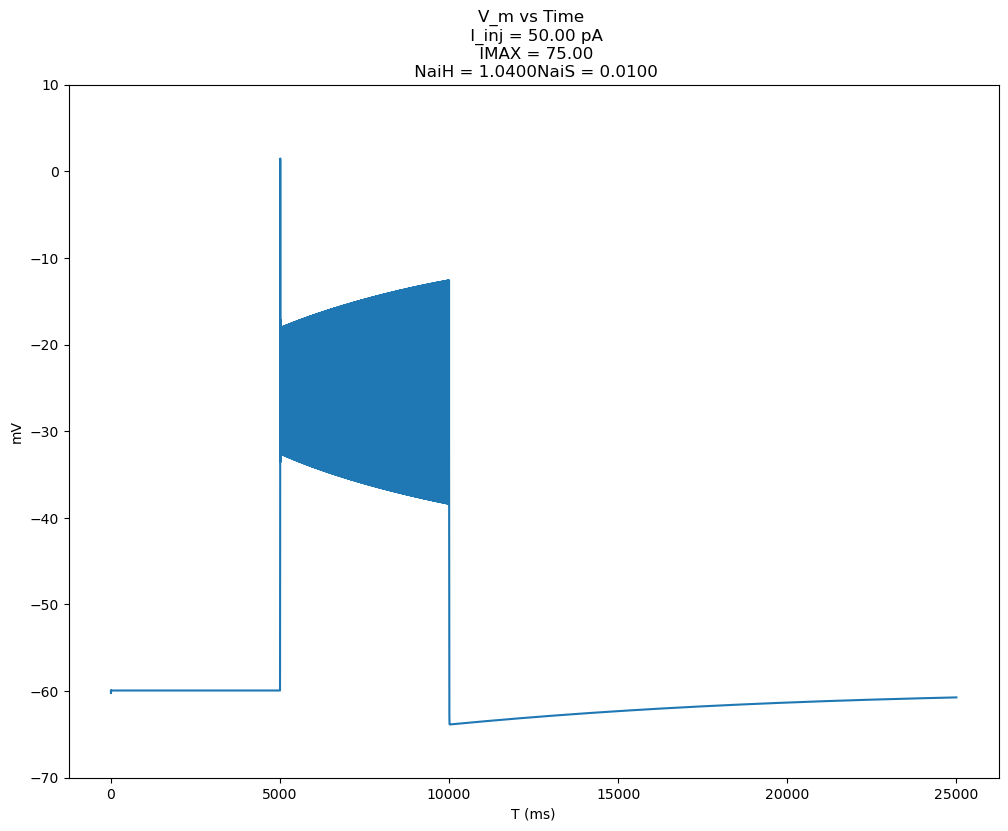

In [ ]:
def plotVCell():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, Vcell)
        plt.title('V_m vs Time \n I_inj = %2.2f pA' %I_pulse
                    + '\n IMAX = %2.2f' %Imaxpump
                    # + '\n ZAP = %2.4f' %I_ZapMax
                    + '\n NaiH = %2.4f' %naih + 'NaiS = %2.4f' %nais) ### Added extra labels
        plt.xlabel('T (ms)')
        plt.ylabel('mV')
        plt.ylim(-70, 10)
        #axes = plt.gca()  
        #axes.yaxis.grid()
        plt.show()
plotVCell() #Comment Out if you don't want to output the graphs

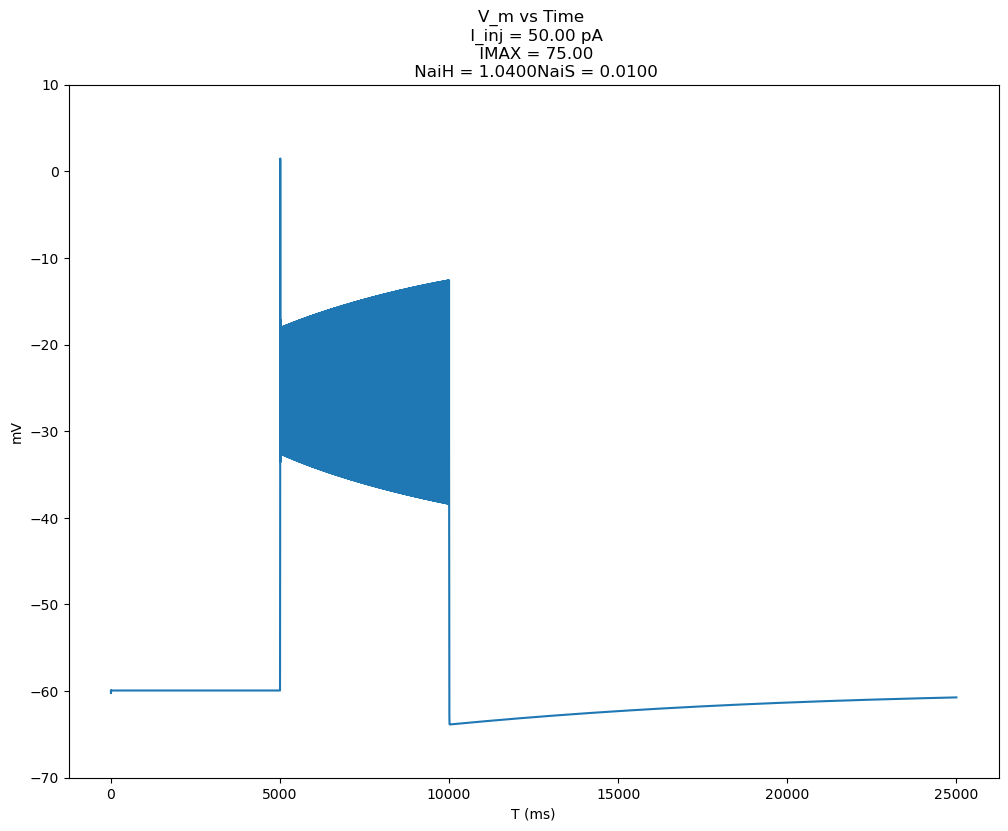

Your simulations are successfully complete!


In [ ]:
    ### Plotting Simulation Functions
    # Plot Voltage and stars the Peaks
    def plotPeaks():
        plt.figure(figsize=(12,9))
        plt.plot(x)
        plt.plot(peaks, x[peaks], "x")
        # plt.xlim((tHold-100)*inv_dt, (tPulseEnd+5000)*inv_dt) ## 100 ms before, 200 ms after current injection
        # plt.plot(np.zeros_like(x), "--", color="gray")
        plt.title('V vs T \n I_inj = %2.1f pA' %I_pulse)
        plt.xlabel('time in microseconds')
        plt.ylabel('mV')   
        plt.show()
    #plotPeaks() #Comment Out if you don't want to output the graphs
    
    # Plot the Voltage and stars troughs
    def plotTroughs():
        x = Vcell
        plt.figure(figsize=(12,9))
        plt.plot(x)
        plt.plot(trough_clp, x[trough_clp], "x")
        plt.title('V vs T \n I_inj = %2.1f pA' %I_pulse)
        plt.xlabel('time in microseconds')
        plt.ylabel('mV')  
        plt.show()
    #plotTroughs() #Comment Out if you don't want to output the graphs
    
    # Plot VM (Membrane Voltage) vs Time, Main Voltage Plotting Function
    def plotVCell():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, Vcell)
        plt.title('V_m vs Time \n I_inj = %2.2f pA' %I_pulse
                    + '\n IMAX = %2.2f' %Imaxpump
                    # + '\n ZAP = %2.4f' %I_ZapMax
                    + '\n NaiH = %2.4f' %naih + 'NaiS = %2.4f' %nais) ### Added extra labels
        plt.xlabel('T (ms)')
        plt.ylabel('mV')
        plt.ylim(-70, 10)
        #axes = plt.gca()  
        #axes.yaxis.grid()
        plt.show()
    plotVCell() #Comment Out if you don't want to output the graphs
    
    # Plot Current Injection (all the different current injectors)
    def plotInjCurrent():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec,    inj_switch*I_inj(t_vec)) 
        plt.xlabel('time (ms)')
        plt.ylabel('Inj Current, pA')
        plt.title('Injection Current vs Time \n I_inj = %2.1f pA' %I_pulse
                    + '\n Imaxpump = %3.0f' %Imaxpump)
        #plt.ylim(0,50) 
        plt.show()
    #plotInjCurrent() #Comment Out if you don't want to output the graph
    
    # Plot Zap Frequency
    def plotZapFreq():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, ZapFreq(t_vec))
        plt.xlabel('time (ms)')
        plt.ylabel('Frequency (Hz)')
        plt.title('Zap Frequency vs Time \n I_inj = %2.1f pA' %I_pulse
                    + '\n Imaxpump = %3.0f' %Imaxpump)
        #plt.ylim(0,50) 
        plt.show()
    #plotZapFreq() #Comment Out if you don't want to output the graph
    
    # Plot Internal Sodium Concentration [Na]
    def plotNaint():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, Nai)
        plt.title('Internal [Na] vs Time \n '
                    +'I_inj = %2.1f pA \n' %I_pulse 
                        + 'Imaxpump = %3.0f' %Imaxpump)
        plt.xlabel('time (ms)')
        plt.ylabel(r'$[Na]_{int}$ in M')
        #plt.ylim(0.0245, 0.0265) #Commented out to get an auto-generated range
        plt.show()
    #plotNaint() #Comment Out if you don't want to output the graphs

    # Plot Pump Current
    def plotIpump_i():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, I_pump(Nai))
        plt.xlabel('time (ms)')
        plt.ylabel('Pump Current, pA')
        plt.title('Pump Current vs Time \n I_inj = %2.1f pA' %I_pulse
                    + '\n Imaxpump = %3.0f' %Imaxpump)
        # plt.ylim(0 , 1.1*Imaxpump) 
        plt.show()
    #plotIpump_i() #Comment Out if you don't want to output the graph

    # Plot Dynamic E_Na
    def plotDynENa():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, E_NaSwitch(Nai))
        plt.xlabel('time (ms)')
        plt.ylabel('Na Reversal Potential (mV)')
        plt.title('Dynamic Sodium Reversal Potential (E_Na) vs T')
        plt.show()
    #plotDynENa() #Comment Out if you don't want to output the graph
    
    # Plot Instantenous Frequency
    def plotISF():
        "Plot Instantenous Spike Frequnecy over the simulation time"
        plt.figure()
        plt.plot(realspktimesminusone_array, ifr_array, 'o-')
        plt.title('IFR Curve' + 'I_inj = %2.2f pA' %I_pulse               
            + '\n Imaxpump = %3.0f' %Imaxpump               
            + ', nais = %1.4f' %nais)
        plt.xlabel('time in ms')
        plt.ylabel('IFR (Hz)')
    #plotISF()
    
    # Plot Full Leak Current 
    def plot_fullI_leak():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, I_leak_NA(Vcell, Nai) + I_leak_K(Vcell)) #remember to insert all the called parameters!
        plt.xlabel('time (ms)')
        plt.ylabel('Leak Current, pA')
        plt.title('Full Leak Current vs Time \n I_inj = %2.1f pA' %I_pulse
                    + '\n Imaxpump = %3.0f' %Imaxpump)
        #plt.ylim(0,50) 
        plt.show()
    #plot_fullI_leak() #Comment Out if you don't want to output the graph
    
    # Plod Sodium [Na] Leak Current
    def plotI_leakNA():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, I_leak_NA(Vcell, Nai)) #remember to insert all the called parameters!
        plt.xlabel('time (ms)')
        plt.ylabel('Leak Current, pA')
        plt.title('Sodium Component Leak Current vs Time \n I_inj = %2.1f pA' %I_pulse
                    + '\n Imaxpump = %3.0f' %Imaxpump)
        #plt.ylim(0,50) 
        plt.show()
    #plotI_leakNA() #Comment Out if you don't want to output the graph
    # Plot Full Leak Current 

    def plotI_leakK():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, I_leak_K(Vcell)) #remember to insert all the called parameters!
        plt.xlabel('time (ms)')
        plt.ylabel('Leak Current, pA')
        plt.title('Potassium Component Leak Current vs Time \n I_inj = %2.1f pA' %I_pulse
                    + '\n Imaxpump = %3.0f' %Imaxpump)
        #plt.ylim(0,50) 
        plt.show()
    #plotI_leakK() #Comment Out if you don't want to output the graph
    
    # Plot Fast Potassium [Kf] Current
    def plotI_Kf():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, I_Kf(Vcell, mKf, hKf1, hKf2)) #remember to insert all the called parameters!
        plt.xlabel('time (ms)')
        plt.ylabel('Fast Potassium Current, pA')
        plt.title('Kf Current vs Time \n I_inj = %2.1f pA' %I_pulse
                    + '\n Imaxpump = %3.0f' %Imaxpump)
        #plt.ylim(0,50) 
        plt.show()
    #plotI_Kf() #Comment Out if you don't want to output the graph
    
    # Plot Slow Potassium [Ks] Current
    def plotI_Ks():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, I_Ks(Vcell,n)) #remember to insert all the called parameters!
        plt.xlabel('time (ms)')
        plt.ylabel('Slow Potassium Current, pA')
        plt.title('Ks Current vs Time \n I_inj = %2.1f pA' %I_pulse
                    + '\n Imaxpump = %3.0f' %Imaxpump)
        #plt.ylim(0,50) 
        plt.show()
    #plotI_Ks() #Comment Out if you don't want to output the graph
    
    # Plot Transient Sodium [NaT] Current
    def plotI_NaT():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, I_NaT(Vcell, mNaT, hNaT, Nai)) #remember to insert all the called parameters!
        plt.xlabel('time (ms)')
        plt.ylabel('Transient Sodium, pA')
        plt.title('NaT Current vs Time \n I_inj = %2.1f pA' %I_pulse
                    + '\n Imaxpump = %3.0f' %Imaxpump)
        #plt.ylim(0,50) 
        plt.show()
    #plotI_NaT() #Comment Out if you don't want to output the graph
    
    # Plot Persistent Sodium [NaP]
    def plotI_NaP():
        plt.figure(figsize=(12,9))
        plt.plot(t_vec, I_NaP(Vcell, mNaP, Nai)) #remember to insert all the called parameters!
        plt.xlabel('time (ms)')
        plt.ylabel('Persistent Sodium, pA')
        plt.title('NaP Current vs Time \n I_inj = %2.1f pA' %I_pulse
                    + '\n Imaxpump = %3.0f' %Imaxpump)
        #plt.ylim(0,50) 
        plt.show()
    #plotI_NaP() #Comment Out if you don't want to output the graph
    
# Plot Frequency-Injection 
def plotFI():
        "Plot initial, final and mean IFR per current injection"
        plt.figure()
        plt.plot(inj, mean_ifrs, 'o-b', label = 'mean ifr')
        plt.plot(inj, ifr[0]   , 'o-r', label = 'initial ifr')
        plt.plot(inj, ifr[-1]  , 'o-g', label = 'final ifr')
        plt.legend(loc='upper left')
        plt.title('FI Curve'              
                + '\n Imaxpump = %3.0f' %Imaxpump               
                + '\n nais = %1.4f' %nais
                + '\n NaiH = %1.4f' %naih)
        plt.xlabel('pA Injection')
        plt.ylabel('IFR (Hz)')
#plotFI()
        
        ### Sweeps
        #Imaxpump = Imaxpump + Imaxpump_step
        #nais = nais + nais_step
naih = naih + naiH_step

#Imaxpump = Imaxpump_start
#nais = nais_start
#naih = naih + naiH_start

# =============================================================================
print("Your simulations are successfully complete!")


In [ ]:

# In[ ]:
# =============================================================================
# Plot: Functions of individual Current Steps
# =============================================================================   
""" 
Plots figures from the last [i] (instance) of the current injection range. 
Can manually call these functions by typing 'plot____()' in the IPython Console. 
"""
def plotPeakAHP():
    "AHP Peak Amplitude per current injection step"
    plt.figure()
    plt.plot(inj, ahp_amp, 'o-b')
    plt.title('AHP Peak Amplitude vs Current Injection'
              +'\n Imaxpump = %3.0f' %Imaxpump               
              + ', nais = %1.4f' %nais)
    plt.xlabel('pA injection')
    plt.ylabel('mV')
def plotHalfAHPTime():
    "Time it takes for AHP to return halfway to baseline, per current injection"
    plt.figure()
    plt.plot(inj, ahp_halfdur, 'o-b')
    plt.title('Half Duration of AHP vs Current Injection'               
              + '\n Imaxpump = %3.0f' %Imaxpump               
              + ', nais = %1.4f' %nais
              + ',\n naih = %1.4f' %naih)
    plt.xlabel('pA injection')
    plt.ylabel('ms') 
def plotDelay():
    "Delay to First Spike per current injection"
    plt.figure()
    plt.plot(inj, delay, 'or')
    plt.title('Delay to First Spike \n Isopotential, '               
              + '\n Imaxpump = %3.0f' %Imaxpump               
              + ', nais = %1.4f' %nais)
    plt.xlabel('I_inj(pA)')
    plt.ylabel('Delay (ms)')
def plotMeanVcell():
    "Average voltage at AP troughs per current injection"
    plt.figure()
    plt.plot(inj, mean_Vcell, 'oy')
    plt.title('Average Membrane Voltage'               
              + '\n Imaxpump = %3.0f' %Imaxpump 
              + ', nais = %1.4f' %nais)
    plt.xlabel('I_inj (pA)')
    plt.ylabel('Average Membrane Voltage (mV)')  
def plotAHPTroughIFR():
    "Plotting AHP Trough Amplitudes versus Mean Spiking Frequency"
    plt.figure()
    plt.plot(mean_ifrs, ahp_amp, 'o-b')
    plt.title('AHP Trough Amplitudes vs Mean Spiking Frequency'
              +'\n Imaxpump = %3.0f' %Imaxpump               
              + ', nais = %1.4f' %nais)
    plt.xlabel('Average Spike Frequency (Hz)')
    plt.ylabel('AHP Amplitudes (mV)')
def plotAHPTimeIFR():
    "Plotting AHP Half Duration versus Mean Spiking Frequency"
    plt.figure()
    plt.plot(mean_ifrs, ahp_halfdur, 'o-b')
    plt.title('AHP Half Duration vs. Mean Spiking Frequency'
              +'\n Imaxpump = %3.0f' %Imaxpump               
              + ', nais = %1.4f' %nais)
    plt.xlabel('Average Spike Frequency (Hz)')
    plt.ylabel('AHP Half Duration Time in ms')

# =============================================================================
# Plot: Functions relating to most recent simulation over time
# =============================================================================   
def plotIpump():
    "Pump Current vs time of the final i within current injection range"
    plt.figure()
    plt.plot(t_vec, I_pump(Nai))
    plt.xlabel('time (ms)')
    plt.ylabel('Pump Current, pA')
    plt.title('Pump Current vs T \n I_inj = %2.1f pA' %I_pulse)   
def plotVcell():
    "Membrane Voltage of most recent simulation"    
    plt.figure(figsize=(20,10))
    plt.plot(t_vec, Vcell)
    plt.title('V vs T \n I_inj = %2.1f pA' %I_pulse)
    plt.xlabel('T (ms)')
    plt.ylabel('mV')
    plt.xlim(9900, 20000)
    axes = plt.gca()
    axes.yaxis.grid()
def plotFV():
    "Frequency-Voltage Curve"
    plt.figure()
    plt.plot(mean_Vcell, mean_ifrs, 'ok')
    plt.title('F-V Curve'               
              + '\n Imaxpump = %3.0f' %Imaxpump 
              + ', nais = %1.4f' %nais)
    plt.xlabel('Average Membrane Voltage (mV)')
    plt.ylabel('Average IFR (Hz)')
